## Installation

In [ ]:
!pip install pyPLNmodels

### Getting Started with the PLN Model Package

We assume the data follows a Poisson log-normal (PLN) model:

$$ \mathbf{Y}_i \sim \mathcal{P}(\exp(\mathbf{Z}_i)), \quad \mathbf{Z}_i \sim \mathcal{N}(\mathbf{o}_i + \mathbf{B}^{\top} \mathbf{x}_i, \mathbf{\Sigma}). $$

The package aims to retrieve the latent variables $\mathbf{Z}$ from the observed counts and to infer the parameters $\mathbf{B}$ (`coef` in the package) and $\mathbf{\Sigma}$ (`covariance`), of size $d\times p $ and $p\times p$ respectively. Users can provide:

- A matrix of counts $\mathbf{Y}$ of size $n \times p$ (`endog`)
- A matrix of covariates $\mathbf{X}$ of size $n \times d$ (`exog`)
- An offsets matrix of size $n \times p$ (`offsets`)

Default values are available for the covariates and offsets if they are not provided, but the count matrix is required. 

In the following, we consider the `Pln` class implementing the PLN model as well as two variants of PLN: `PlnPCA` and `ZIPln`. We begin by analyzing a dataset without covariates, followed by an analysis that includes covariates.



### How to specify a model
Each model can be specified in two distinct manners:

* by formula (similar to R), where a data frame is passed and the formula is specified using the  ```from_formula``` initialization:

```model = Model.from_formula("endog ~ 1  + covariate_name ", data = data)# not run```

We rely to the [patsy](https://github.com/pydata/patsy) package for the formula parsing.

* by specifying the endog, exog, and offsets matrices directly:

```model = Model(endog = endog, exog = exog, offsets = offsets)# not run```


### Import the needed functions

In [ ]:
from pyPLNmodels import load_scrna, load_model, Pln, PlnPCA, PlnPCAcollection, ZIPln, load_microcosm
import matplotlib.pyplot as plt

# Without covariates

### Load the data

We load a subsample of the [scMARK](https://www.biorxiv.org/content/10.1101/2021.12.08.471773v1) dataset. The loaded dataset consists of 469 cells (rows) and 200 genes (columns). The counts represent the number of reads sequenced for each cell, mapped to each gene. The cell types are also provided.

In [ ]:
data  = load_scrna(return_labels=True) 
counts = data["endog"]
labels = data["labels"]

### `Pln`

This is the building-block of the models implemented in this package. It fits a Poisson lognormal model to the data:

In [ ]:
pln = Pln(counts)
pln.fit()

In [ ]:
print(pln)

#### Once fitted, we can extract multiple variables:

In [ ]:
gaussians = pln.latent_variables
print(gaussians.shape)

In [ ]:
model_param = pln.model_parameters
print(model_param["coef"].shape)
print(model_param["covariance"].shape)

### `PlnPCA` 
This model excels in dimension reduction and is capable of scaling to
high-dimensional count data ($p >> 1$). It represents a variant of the PLN
model, incorporating a rank constraint on the covariance matrix. This can be
interpreted as an extension of the [probabilistic
PCA](https://academic.oup.com/jrsssb/article/61/3/611/7083217) for
count data, where the rank determines the number of components in the
probabilistic PCA. Users have the flexibility to define the rank of the
covariance matrix via the `rank` keyword of the `PlnPCA` object. 


In [ ]:
pca = PlnPCA(counts, add_const = True, rank = 5)
pca.fit()

In [ ]:
print(pca)

In [ ]:
print(pca.latent_variables.shape)

In [ ]:
print(pca.model_parameters["components"].shape)
print(pca.model_parameters["coef"].shape)

### Save the model in order to load it back after:

In [ ]:
pca.save() ## You can set a name to the file saved.
dict_init = load_model("PlnPCA_nbcov_1_dim_200_rank_5")
loaded_pca = PlnPCA(counts, add_const = True, dict_initialization=  dict_init)
print(loaded_pca)

### One can specify multiple ranks simultaneously within the `PlnPCAcollection` object, and then select the optimal model based on either the AIC (default) or BIC criterion:

In [ ]:
pca_col = PlnPCAcollection(counts, ranks = [5,15,25,40,50])
pca_col.fit()
best_model = pca_col.best_model()

In [ ]:
pca_col.show()

### `ZIPln`

The `ZiPln` model, a variant of the PLN model, is designed to handle zero
inflation in the data. It is defined as follows:

$$Y_{ij}\sim \mathcal W_{ij} \times  P(\exp(Z_{ij})), \quad \mathbf Z_i \sim \mathcal N(\mathbf o_i + \mathbf B ^{\top} \mathbf x_i, \mathbf \Sigma), \quad W_{ij} \sim \mathcal B(\sigma( \mathbf x_i^{0^{\top}}\mathbf B^0_j))$$

This model is particularly beneficial when the data contains a significant
number of zeros. It incorporates additional covariates for the zero inflation
coefficient, which are specified following the pipe `|` symbol in the formula, or via the `exog_inflation` keyword. The inflation can also be row-wise (see the [documentation](https://bbatardiere.pages.mia.inra.fr/pyplnmodels/zipln.html)). 


In [ ]:
zi = ZIPln(counts)
zi.fit()
print(zi)

# Visualization

A set of visualization methods is given to help the user interpret the outputs. The `viz` method performs PCA on the latent variables, while the `viz_positions` function
carries out PCA on the latent variables, adjusted for covariates. Additionally,
the `viz_prob` function provides a visual representation of the zero-inflation
probability.

#### Visualization with `Pln`

In [ ]:
pln.viz(colors=labels)
plt.show()

### Visualization with `PlnPCA`

In [ ]:
best_pca = pca_col.best_model()
best_pca.viz(colors = labels)
plt.show()

#### Visualization with `ZIPln`

In [ ]:
zi.viz(colors = labels)

### What would give a PCA on the log normalize data ? 

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns

In [ ]:
sk_pca = PCA(n_components = 2)
pca_log_counts = sk_pca.fit_transform(np.log(counts + (counts == 0)))
_ = sns.scatterplot(x = pca_log_counts[:,0], y = pca_log_counts[:,1], hue = labels)

### Visualization of the variables

In [ ]:
pln.plot_pca_correlation_circle(["var_1","var_2"], indices_of_variables = [0,1])
plt.show()

In [ ]:
best_pca.plot_pca_correlation_circle(["var_1","var_2"], indices_of_variables = [0,1])
plt.show()

### Visualization of each components of the PCA


In [ ]:
pln.pca_pairplot(colors = labels, n_components = 5)

# With covariates

### High benefits of zero-inflation
Some datasets are highly inflated (> 90% of zeros) and one need to take into account this zero-inflation. We load (a subsample of) the [microcosm](https://pubmed.ncbi.nlm.nih.gov/37308970/) dataset. In this dataset, three body
sites (for 45 cows) in addition to the milk of the 4 teats were sampled (vagina (V), milk (M),
Oral (O), Nasal (N)) at 4 times points: 1 week before calving (except for the milk), 1 month (1M),
3 months (3M) and 7 months (7M) after calving. 

We want to **remove the effect of the site in order to observe only the effect of the time**. We compare the `ZIPln` and the `Pln`. Using the ZIPln model will remove the noise induced by the zero inflation.

In [ ]:
data_mic = load_microcosm(n_samples =  500, dim =300)

In [ ]:
print("Pourcentage of zeros: ", np.round(np.mean(np.mean(data_mic["endog"] == 0))*100), "%")

In [ ]:
data_mic.keys()

#### Classic Pln 

In [ ]:
no_inflation = Pln.from_formula("endog ~ 1+site", data = data_mic)
no_inflation.fit()
no_inflation.viz(colors = data_mic["site"])

### With zero-inflation

In [ ]:
inflation = ZIPln.from_formula("endog ~ 1 + site", data = data_mic)
inflation.fit()
inflation.viz(colors = data_mic["site"])

The data is very well separated. We have to remove the effect of the site to see the effect of the time.

#### The `viz_positions` method remove the effect of covariates specified in the formula: 

In [ ]:
_ = inflation.viz_positions(colors = data_mic["time"])
_ = inflation.viz_positions(colors = data_mic["site"])

#### However, the effect of the time is still present:

In [ ]:
_ = inflation.viz_positions(colors = data_mic["time"])

The effect of the site is completely absent, but the effect of the time is present. If you want to extract those "not-site-dependent" positions, you can use the `latent_positions` attribute:


In [ ]:
latent_pos = inflation.latent_positions

Specifiying "endog ~ 1 + time" in the formula, the `latent_positions` attribute would contain the effect on the site only. 

#### One can also visualize the latent probabilites

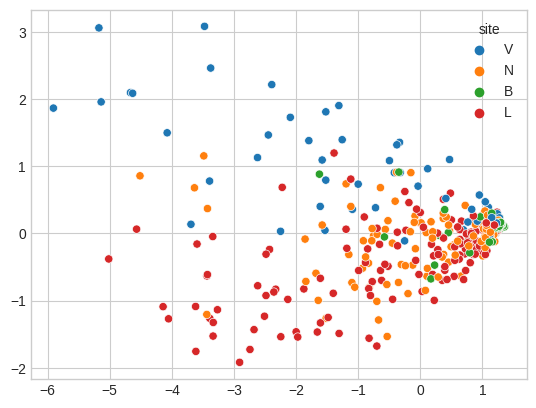

In [36]:
_ = inflation.viz_prob(colors = data_mic["site"])